# beetle: PSAR smoothing の評価

In [60]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [61]:
import datetime
import re
from collections import deque
from sys import stdout

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates
from scipy.interpolate import make_smoothing_spline

from beetle.beetle_psar import RealtimePSAR
from funcs.tse import get_ticker_name_list

pattern = re.compile(r".+([0-9]{4})([0-9]{2})([0-9]{2})\.xlsx")

In [62]:
name_excel = "../excel/tick_20250707.xlsx"
ticker = "7011"
# ticker = "7203"
# ticker = "8306"

m = pattern.match(name_excel)
if m:
    year = m.group(1)
    month = m.group(2)
    day = m.group(3)
else:
    year = "1970"
    month = "01"
    day = "01"
date_str = f"{year}-{month}-{day}"
df = pd.read_excel(name_excel, sheet_name=ticker)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(t) for t in df["Time"]])
df

,Time,Price
2025-07-07 09:00:00.945624,1.751846e+09,3362
2025-07-07 09:00:02.343719,1.751846e+09,3362
2025-07-07 09:00:02.932775,1.751846e+09,3364
2025-07-07 09:00:03.937222,1.751846e+09,3364
2025-07-07 09:00:04.934612,1.751846e+09,3370
...,...,...
2025-07-07 15:24:45.933281,1.751869e+09,3406
2025-07-07 15:24:46.939378,1.751869e+09,3406
2025-07-07 15:24:47.943283,1.751869e+09,3407
2025-07-07 15:24:48.939748,1.751869e+09,3407


## スムージング処理

In [63]:
total = len(df)
df["x"] = [r for r in range(len(df))]

n = 600
xs_deque = deque(maxlen=n)
prices_deque = deque(maxlen=n)

for i, t in enumerate(df.index):
    x = df.at[t, "x"]
    price = df.at[t, "Price"]

    xs_deque.append(x)
    prices_deque.append(price)

    if len(xs_deque) > 5:
        lam = 10**6
        spl = make_smoothing_spline(xs_deque, prices_deque, lam=lam)
        df.at[t, "y"] = spl(x)
        stdout.write(f"\rCompleted {i + 1} / {total}")
        stdout.flush()
df

Completed 19410 / 19410

,Time,Price,x,y
2025-07-07 09:00:00.945624,1.751846e+09,3362,0,NaN
2025-07-07 09:00:02.343719,1.751846e+09,3362,1,NaN
2025-07-07 09:00:02.932775,1.751846e+09,3364,2,NaN
2025-07-07 09:00:03.937222,1.751846e+09,3364,3,NaN
2025-07-07 09:00:04.934612,1.751846e+09,3370,4,NaN
...,...,...,...,...
2025-07-07 15:24:45.933281,1.751869e+09,3406,19405,3405.186336
2025-07-07 15:24:46.939378,1.751869e+09,3406,19406,3405.246578
2025-07-07 15:24:47.943283,1.751869e+09,3407,19407,3405.348658
2025-07-07 15:24:48.939748,1.751869e+09,3407,19408,3405.447888


## チャート

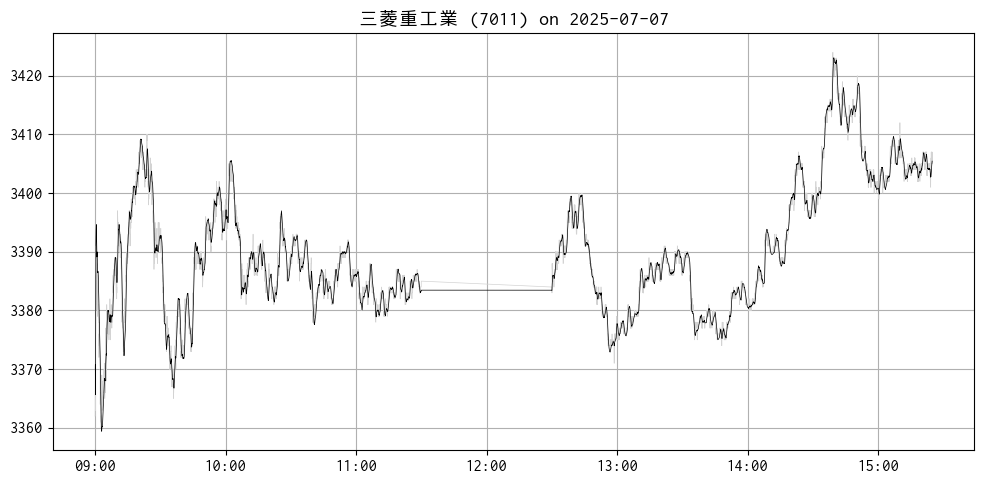

In [64]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 12
# plt.style.use("dark_background")

ax = dict()
n = 1

if n > 1:
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
        height_ratios=[3 if i == 0 else 1 for i in range(n)],
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid()
else:
    fig, ax[0] = plt.subplots(figsize=(10, 5))
    ax[0].grid()

ax[0].plot(df["Price"], color="lightgray", linewidth=0.5)
ax[0].plot(df["y"], color="black", linewidth=0.5)

ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
dict_name = get_ticker_name_list([ticker])
ax[0].set_title(f"{dict_name[ticker]} ({ticker}) on {date_str}")

plt.tight_layout()
# plt.savefig(f"screenshots/psar_smoothing_{date_str}_{ticker}.png")
plt.show()